# Monge-Ampère equations

In [1]:
!poetry --version > /dev/null 2> /dev/null || pip install poetry
!python -c 'import notebooks_lib' 2> /dev/null || pip install git+https://github.com/gbonnet1/notebooks.git
!povray --version > /dev/null 2> /dev/null || apt-get install -y povray

In [2]:
from dataclasses import dataclass

import agd.FiniteDifferences as fd
import agd.LinearParallel as lp
import matplotlib.pyplot as plt
import numpy as np
from agd import Domain, Selling
from agd.AutomaticDifferentiation.Optimization import newton_root
from agd.AutomaticDifferentiation.Sparse import spAD

from notebooks_lib.reflector import simulate_reflector

In [3]:
# TODO: alternative to this?
def spad_sum(a):
    if not isinstance(a, spAD):
        return

    index, inverse = np.unique(a.index, axis=-1, return_inverse=True)
    coef = np.zeros(index.shape)

    for i in range(index.shape[-1]):
        coef[..., i] = np.sum(a.coef[..., inverse == i], axis=-1)

    a.index = index
    a.coef = coef

In this notebook, we aim to solve Monge-Ampère equations of the form
\begin{equation}
    \det (D^2 u(x) - A(x, u(x), D u(x))) = B(x, u(x), D u(x))
\end{equation}
on an open domain $\Omega \subset \mathbb{R}^2$, where functions $A$ and $B$ take values in $\mathcal{S}_2$ and $\mathbb{R}_+$ respectively. We look for an *admissible* solution to the previous equation, that is, a solution $u \colon \overline \Omega \to \mathbb{R}$ such that
\begin{equation}
    D^2 u(x) - A(x, u(x), D u(x)) \geq 0.
\end{equation}

## 1. Reformulation of the equation

Let $M \in \mathcal{S}_2^{++}$, $\mathcal{D} \in \mathcal{S}_2^{++}$ be such that $\det\mathcal{D} = 1$, and $\lambda_1$, $\lambda_2 \geq 0$ be the eigenvalues of the product $\mathcal{D} M$. Then by the inequality of arithmetic and geometric means,
\begin{equation}
    2 (\det M)^{1/2}
    = 2 (\det (\mathcal{D} M))^{1/2}
    = 2 (\lambda_1 \lambda_2)^{1/2}
    \leq \lambda_1 + \lambda_2
    = \langle \mathcal{D}, M \rangle,
\end{equation}
with equality when $\mathcal{D} = (\det M)^{1/2} M^{-1}$. Thus
\begin{equation}
    2 (\det M)^{1/2}
    = \inf_{\substack{\mathcal{D} \in \mathcal{S}_2^{++} \\ \det \mathcal{D} = 1}} \langle \mathcal{D}, M \rangle
    = \inf_{\substack{\mathcal{D} \in \mathcal{S}_2^{++} \\ \operatorname{Tr}(\mathcal{D}) = 1}} (\det \mathcal{D})^{-1/2} \langle \mathcal{D}, M \rangle,
\end{equation}
and this equality extends to $M \in \mathcal{S}_2^+$. Therefore admissible solutions to the Monge-Ampère equation are also solution to
\begin{equation}
    \sup_{\substack{\mathcal{D} \in \mathcal{S}_2^{++} \\ \operatorname{Tr}(\mathcal{D}) = 1}} \left(2 B(x, u(x), D u(x))^{1/2} - (\det \mathcal{D})^{-1/2} \langle \mathcal{D}, D^2 u(x) - A(x, u(x), D u(x)) \rangle\right) = 0.
\end{equation}
Multiplying by $(\det \mathcal{D})^{1/2}$ inside the supremum yields the reformulation
\begin{equation}
    \max_{\substack{\mathcal{D} \in \mathcal{S}_2^+ \\ \operatorname{Tr}(\mathcal{D}) = 1}} \left(2 (\det \mathcal{D})^{1/2} B(x, u(x), D u(x))^{1/2} - \langle \mathcal{D}, D^2 u(x) - A(x, u(x), D u(x)) \rangle\right) = 0.
\end{equation}
We propose to discretize the last equation, which has the benefit that its solutions are always admissible for the Monge-Ampère equation.

## 2. Discretization

We discretize the reformulated equation on a grid $\mathcal{G}_h := \Omega \cap h \mathbb{Z}^2$, for some discretization step $h > 0$.

Let $u \colon \mathcal{G}_h \to \mathbb{R}$ and $x \in \mathcal{G}_h$. If it makes sense (we discuss handling of boundary conditions in later sections), we define
\begin{equation}
    D_h u(x) := \frac{1}{2 h} \begin{pmatrix}
        u(x + h e_1) - u(x - h e_1) \\
        u(x + h e_2) - u(x - h e_2)
    \end{pmatrix},
\end{equation}
where $(e_1, e_2)$ is the canoncial basis of $\mathbb{R}^2$. We also define, for $e \in \mathbb{Z}^2$ and $A \in \mathcal{S}_2$,
\begin{equation}
    \Delta_h^e [u, A](x) := \frac{u(x + h e) + u(x - h e) - 2 u(x)}{h^2} - \langle e, A e \rangle,
\end{equation}
and for any family $v = (v_i)_{1 \leq i \leq m}$ of vectors of $\mathbb{Z}^2$,
\begin{equation}
    \Delta_h^v [u, A](x) := (\Delta_h^{v_i} [u, A](x))_{1 \leq i \leq m}.
\end{equation}
For any such family $v$, we define $\mathcal{S}^+(v) \subset \mathcal{S}_2^+$ as
\begin{equation}
    \mathcal{S}^+(v) := \sum_{i=1}^m \mathbb{R}_+ v_i v_i^\top.
\end{equation}

The *stencil* of the numerical scheme is described by three sets $V_1 \subset \mathbb{Z}^2$, $V_2 \subset (\mathbb{Z}^2)^2$, and $V_3 \subset (\mathbb{Z}^2)^3$ such that

* Any family $v \in V_3$ is a superbase of $\mathbb{Z}^2$, meaning that $\det(v_1, v_2) = \pm 1$ and $v_1 + v_2 + v_3 = 0$. Note that this also implies that $\det(v_2, v_3) = \det(v_3, v_1) = \pm 1$.
* Any family $v \in V_2$ is a basis of $\mathbb{Z}^2$, meaning that $\det(v_1, v_2) = \pm 1$, and moreover $\bigcup_{v \in V_2} \{\pm v_1, \pm v_2\} = \bigcup_{v \in v_3} \bigcup_{1 \leq i < j \leq 3} \{\pm v_i, \pm v_j\}$.
* Any vector $v \in V_1$ is irreductible, meaning that its components are coprime, and moreover $\bigcup_{v \in V_1} \{\pm v\} = \bigcup_{v \in V_2} (\{\pm v_1\} \cup \{\pm v_2\})$.

For any superbase $v \in V_3$ and matrix $\mathcal{D} \in \mathcal{S}_2$, the coordinates of $\mathcal{D}$ in the basis $(v_1 v_1^\top, v_2 v_2^\top, v_3 v_3^\top)$ of $\mathcal{S}_2$ are given by *Selling's formula*:
\begin{equation}
    \mathcal{D} = -\sum_{i=1}^3 \langle v_{i+1}^\perp, \mathcal{D} v_{i+2}^\perp \rangle v_i v_i^\top,
\end{equation}
where indices are taken modulo three. Note that $\mathcal{D} \in \mathcal{S}^+(v)$ if and only if $\langle v_i^\perp, \mathcal{D} v_j^\perp \rangle \leq 0$, for any $1 \leq i < j \leq 3$.

We use the following numerical scheme:
\begin{equation}
    \max_{v \in V_3} H(v, B(x, u(x), D_h u(x)), \Delta_h^v [u, A(x, u(x), D_h u(x))](x)) = 0,
\end{equation}
where for any $v \in V_3$, $b \geq 0$, and $\delta \in \mathbb{R}^3$,
\begin{equation}
    H(v, b, \delta) := \max_{\substack{\mathcal{D} \in \mathcal{S}^+(v) \\ \operatorname{Tr}(\mathcal{D}) = 1}} \left(2 (\det \mathcal{D})^{1/2} b^{1/2} + \sum_{i=1}^3 \langle v_{i+1}^\perp, \mathcal{D} v_{i+2}^\perp \rangle \delta_i\right).
\end{equation}

### Computing the maximum

The maximum in the definition of $H$ may be computed explicitly: for any $\rho \in \overline B(0, 1)$, the closed unit ball of $\mathbb{R}^2$, let
\begin{equation}
    \mathfrak{D}(\rho) := \frac{1}{2} \begin{pmatrix}
        1 + \rho_0 & \rho_1 \\
        \rho_1 & 1 - \rho_0
    \end{pmatrix}.
\end{equation}
Then $\{\mathcal{D} \in \mathcal{S}_2^+ \mid \operatorname{Tr}(\mathcal{D}) = 1\} = \{\mathfrak{D}(\rho) \mid \rho \in \overline B(0, 1)\}$. Moreover, for $\rho \in \overline B(0, 1)$, $2 \det (\mathfrak{D}(\rho))^{1/2} = (1 - |\rho|^2)^{1/2}$, and for $v \in V_3$,
\begin{equation}
    (-\langle v_{i+1}^\perp, \mathfrak{D}(\rho) v_{i+2}^\perp \rangle)_{1 \leq i \leq 3} = W \rho + w
\end{equation}
where
\begin{equation}
    W := \frac{1}{2} \begin{pmatrix}
        v_{2,1} v_{3,1} - v_{2,2} v_{3,2} & v_{2,1} v_{3,2} + v_{2,2} v_{3,1} \\
        v_{1,1} v_{3,1} - v_{1,2} v_{3,2} & v_{1,1} v_{3,2} + v_{1,2} v_{3,1} \\
        v_{1,1} v_{2,1} - v_{1,2} v_{2,2} & v_{1,1} v_{2,2} + v_{1,2} v_{2,1}
    \end{pmatrix},
\end{equation}
\begin{equation}
    w := -\frac{1}{2} \begin{pmatrix}
        \langle v_2, v_3 \rangle \\
        \langle v_1, v_3 \rangle \\
        \langle v_1, v_2 \rangle
    \end{pmatrix}.
\end{equation}
Remark that the expression of the matrix $Q := W W^\top$ simplifies to
\begin{equation}
    Q = \frac{1}{4} \begin{pmatrix}
        |v_2|^2 |v_3|^2 & \langle v_1, v_2 \rangle |v_3|^2 & \langle v_1, v_3 \rangle |v_2|^2 \\
        \langle v_1, v_2 \rangle |v_3|^2 & |v_1|^2 |v_3|^2 & \langle v_2, v_3 \rangle |v_1|^2 \\
        \langle v_1, v_3 \rangle |v_2|^2 & \langle v_2, v_3 \rangle |v_1|^2 & |v_1|^2 |v_2|^2
    \end{pmatrix}.
\end{equation}
The definition of $H$ may be rewritten as
\begin{equation}
    H(v, b, \delta) = \max_{\substack{\rho \in \overline B(0, 1) \\ W \rho + w \geq 0}} \left(b^{1/2} (1 - |\rho|^2)^{1/2} - \langle W \rho + w, \delta \rangle\right),
\end{equation}
where the inequality $W \rho + w \geq 0$ must hold elementwise.

If the optimal $\rho$ is such that $W \rho + w > 0$, then by convexity,
\begin{equation}
    H(v, b, \delta) = \max_{\rho \in \overline B(0, 1)} \left(b^{1/2} (1 - |\rho|^2)^{1/2} - \langle W \rho + w, \delta \rangle\right) = (b + \langle \delta, Q \delta \rangle)^{1/2} - \langle w, \delta \rangle,
\end{equation}
and the maximum is attained at point
\begin{equation}
    \rho_*(v, b, \delta) := -\frac{W^\top \delta}{(b + \langle \delta, Q \delta \rangle)^{1/2}}.
\end{equation}

Note that the inequality $W \rho_*(v, b, \delta) \geq 0$ is equivalent to $Q \delta \leq (b + \langle \delta, Q \delta \rangle)^{1/2} w$. To handle cases where the constraint $W \rho + w \geq 0$ is saturated in the definition of $H$, we rewrite the numerical scheme as
\begin{equation}
    \max_{i \in \{2, 3\}} \max_{v \in V_i} H_i(v, B(x, u(x), D_h u(x)), \Delta_h^v [u, A(x, u(x), D_h u(x))](x)) = 0,
\end{equation}
where
\begin{equation}
    H_3(v, b, \delta) := \begin{cases}
        (b + \langle \delta, Q \delta \rangle)^{1/2} - \langle w, \delta \rangle &\text{if } Q \delta \leq (b + \langle \delta, Q \delta \rangle)^{1/2} w, \\
        -\infty &\text{else},
    \end{cases}
\end{equation}
and
\begin{equation}
    H_2(v, b, \delta) := \max_{t \in [-1, 1]} \left(2 \left(\det \left(\frac{1+t}{2} \frac{v_1 v_1^\top}{|v_1|^2} + \frac{1-t}{2} \frac{v_2 v_2^\top}{|v_2|^2}\right)\right)^{1/2} b^{1/2} - \frac{1+t}{2 |v_1|^2} \delta_1 - \frac{1-t}{2 |v_2|^2} \delta_2\right).
\end{equation}

The maximum in the definition of $H_2$ may also be computed exactly: for any $v \in V_2$ and $t \in [-1, 1]$, we compute that
\begin{equation}
    2 \left(\det \left(\frac{1+t}{2} \frac{v_1 v_1^\top}{|v_1|^2} + \frac{1-t}{2} \frac{v_2 v_2^\top}{|v_2|^2}\right)\right)^{1/2}
    = \frac{|\det(v_1, v_2)|}{|v_1| |v_2|} (1 - t^2)^{1/2}
    = \frac{1}{|v_1| |v_2|} (1 - t^2)^{1/2}.
\end{equation}
We deduce that
\begin{equation}
    H_2(v, b, \delta) = \left(\frac{b}{|v_1|^2 |v_2|^2} + \left(\frac{\delta_1}{2 |v_1|^2} - \frac{\delta_2}{2 |v_2|^2}\right)^2\right)^{1/2} - \left(\frac{\delta_1}{2 |v_1|^2} + \frac{\delta_2}{2 |v_2|^2}\right),
\end{equation}
which we write as
\begin{equation}
    H_2(v, b, \delta) = (\omega_0 b + \langle \omega_1, \delta \rangle^2)^{1/2} - \langle \omega_2, \delta \rangle
\end{equation}
where
\begin{equation}
    \omega_0 := \frac{1}{|v_1|^2 |v_2|^2},
\end{equation}
\begin{equation}
    \omega_1 := \frac{1}{2} \begin{pmatrix}
        1 / |v_1|^2 \\
        -1 / |v_2|^2
    \end{pmatrix},
\end{equation}
\begin{equation}
    \omega_3 := \frac{1}{2} \begin{pmatrix}
        1 / |v_1|^2 \\
        1 / |v_2|^2
    \end{pmatrix}.
\end{equation}

## 3. Implementation of the scheme

We start by declaring an array `x` of elements of $h \mathbb{Z}^2 \cap [-1, 1]^2$ and a domain $\Omega \subset [-1, 1]^2$.

In [4]:
x = np.stack(np.meshgrid(*(2 * [np.linspace(-1, 1, 40)]), indexing="ij"))
domain_ball = Domain.Ball(radius=0.9)

Instances of the following class represent the stencil used in the scheme. Arrays `V2_indices` and `V3_indices` store, respectively, indices in `V1` of vectors of bases of $V_2$ and superbases of $V_3$, up to a change of sign. We also store arrays `Q`, `w`, `omega0`, `omega1`, and `omega2` of matrices $Q$ and vectors $v$ associated to superbases $v \in V_3$, and of scalars $\omega_0$ and vectors $\omega_1$ and $\omega_2$ associated to bases $v \in V_2$.

In [5]:
@dataclass
class Stencil:
    V1: np.ndarray
    V2: np.ndarray
    V2_indices: np.ndarray
    V3: np.ndarray
    V3_indices: np.ndarray
    Q: np.ndarray
    w: np.ndarray
    omega0: np.ndarray
    omega1: np.ndarray
    omega2: np.ndarray

Using Selling's algorithm, given $\mu \geq 1$, we compute a stencil $V_1$, $V_2$, $V_3$ such that any matrix $\mathcal{D} \in \mathcal{S}_2^{++}$ whose condition number is less than or equal to $\mu$ belongs to $\bigcup_{v \in V_3} \mathcal{S}^+(v)$.

In [6]:
def StencilForConditioning(cond):
    V3 = Selling.SuperbasesForConditioning(cond)
    offsets = V3.reshape((2, -1))

    # Make offsets positive for the lexicographic order, inversing their sign if needed.
    offsets[:, offsets[0] < 0] *= -1
    offsets[:, np.logical_and(offsets[0] == 0, offsets[1] < 0)] *= -1

    V1, indices = np.unique(offsets, axis=1, return_inverse=True)
    V3_indices = indices.reshape(V3.shape[1:])
    V2_indices = np.unique(
        np.sort(
            np.concatenate(
                (V3_indices[[0, 1]], V3_indices[[0, 2]], V3_indices[[1, 2]]), axis=1
            ),
            axis=0,
        ),
        axis=1,
    )
    V2 = V1[:, V2_indices]

    Q = np.zeros((3, 3, V3.shape[2]))
    w = np.zeros((3, V3.shape[2]))

    for i in range(3):
        Q[i, i] = (
            lp.dot_VV(V3[:, (i + 1) % 3], V3[:, (i + 1) % 3])
            * lp.dot_VV(V3[:, (i + 2) % 3], V3[:, (i + 2) % 3])
            / 4
        )
        Q[i, (i + 1) % 3] = (
            lp.dot_VV(V3[:, i], V3[:, (i + 1) % 3])
            * lp.dot_VV(V3[:, (i + 2) % 3], V3[:, (i + 2) % 3])
            / 4
        )
        Q[i, (i + 2) % 3] = (
            lp.dot_VV(V3[:, i], V3[:, (i + 2) % 3])
            * lp.dot_VV(V3[:, (i + 1) % 3], V3[:, (i + 1) % 3])
            / 4
        )
        w[i] = -lp.dot_VV(V3[:, (i + 1) % 3], V3[:, (i + 2) % 3]) / 2

    omega0 = 1 / (lp.dot_VV(V2[:, 0], V2[:, 0]) * lp.dot_VV(V2[:, 1], V2[:, 1]))
    omega1 = 1 / (
        2 * np.stack([lp.dot_VV(V2[:, 0], V2[:, 0]), -lp.dot_VV(V2[:, 1], V2[:, 1])])
    )
    omega2 = 1 / (
        2 * np.stack([lp.dot_VV(V2[:, 0], V2[:, 0]), lp.dot_VV(V2[:, 1], V2[:, 1])])
    )

    return Stencil(V1, V2, V2_indices, V3, V3_indices, Q, w, omega0, omega1, omega2)

In [7]:
stencil = StencilForConditioning(15)

We implement functions $H_3$ and $H_2$ defined above. In practice, instead of a superbase $v \in V_3$ (respectively a basis $v \in V_2$), their first arguments are the associated matrix $Q$ and vector $w$ (respectively the associated scalar $\omega_0$ and vectors $\omega_1$ and $\omega_2$).

In [8]:
def H3(Q, w, b, delta):
    Q_delta = lp.dot_AV(Q, delta)
    r = np.sqrt(b + lp.dot_VV(delta, Q_delta))
    return np.where(np.all(Q_delta <= r * w, axis=0), r - lp.dot_VV(w, delta), -np.inf)

In [9]:
def H2(omega0, omega1, omega2, b, delta):
    return np.sqrt(omega0 * b + lp.dot_VV(omega1, delta) ** 2) - lp.dot_VV(
        omega2, delta
    )

The scheme may be written as
\begin{equation}
    \max_{i \in \{1, 2, 3\}} \max_{v \in V_i} H_i(v, B(x, u(x), D_h u(x)), \Delta_h^v [u, A(x, u(x), D_h u(x))](x)) = 0,
\end{equation}
where
\begin{equation}
    H_1(v, b, \delta) := 2 \left(\det \left(\frac{v v^\top}{|v|^2}\right)\right)^{1/2} b^{1/2} - \frac{\delta}{|v|^2} = -\frac{\delta}{|v|^2}.
\end{equation}
At points $x \in \mathcal{G}_h$ such that $B(x, u(x), D_h u(x)) = 0$, the scheme degenerates to
\begin{equation}
    \max_{v \in V_1} H_1(v, 0, \Delta_h^v [u, A(x, u(x), D_h u(x))](x)) = 0.
\end{equation}
To prevent errors in the automatic differentiation process, in practice we have to handle this case separately, so we implement the function $H_1$ below. Since it does not depend on $b$, we drop the second argument.

In [10]:
def H1(v, delta):
    return -delta / lp.dot_VV(v, v)

We define a function `Scheme` which is shared between implementations of the scheme with different boundary conditions. Given $a \in \mathcal{S}_2$, $b \geq 0$, the stencil $V_1$, $V_2$, $V_3$, and $\Delta_h^{V_1} [u, 0](x)$, it returns
\begin{equation}
    \max_{i \in \{1, 2, 3\}} \max_{v \in V_i} H_i(v, b, \Delta_h^v [u, a](x)).
\end{equation}

In [11]:
def Scheme(a, b, d2u, stencil):
    delta = d2u - lp.dot_VAV(
        np.expand_dims(stencil.V1, (2, 3)),
        np.expand_dims(a, 2),
        np.expand_dims(stencil.V1, (2, 3)),
    )

    spad_sum(b)
    spad_sum(delta)

    # For now, replace `b` with one when it is zero, to prevent errors during automatic
    # differentiation.
    b_zero = b == 0
    b = np.where(b_zero, 1, b)

    residue = -np.inf

    for i in range(stencil.V3.shape[2]):
        residue = np.maximum(
            residue,
            H3(
                stencil.Q[:, :, i, np.newaxis, np.newaxis],
                stencil.w[:, i, np.newaxis, np.newaxis],
                b,
                delta[stencil.V3_indices[:, i]],
            ),
        )

    for i in range(stencil.V2.shape[2]):
        residue = np.maximum(
            residue,
            H2(
                stencil.omega0[i, np.newaxis, np.newaxis],
                stencil.omega1[:, i, np.newaxis, np.newaxis],
                stencil.omega2[:, i, np.newaxis, np.newaxis],
                b,
                delta[stencil.V2_indices[:, i]],
            ),
        )

    # Reset residue to minus infinity where `b` should have been zero.
    residue = np.where(b_zero, -np.inf, residue)

    for i in range(stencil.V1.shape[1]):
        residue = np.maximum(
            residue, H1(stencil.V1[:, i, np.newaxis, np.newaxis], delta[i])
        )

    return residue

## 4. Dirichlet boundary conditions

Let $\mathcal{\overline G}_h := \mathcal{G}_h \cap \partial \Omega$ and $g \colon \partial \Omega \to \mathbb{R}$. We are looking for a function $u \colon \mathcal{\overline G}_h \to \mathbb{R}$ which solves the numerical scheme on $\mathcal{G}_h$ and such that $u(x) = g(x)$ on $\partial \Omega$. Let us explain how we adapt the definitions of finite difference operators $D_h$ and $\Delta_h^e$ near $\partial \Omega$. For any $u \colon \mathcal{\overline G}_h \to \mathbb{R}$, $x \in \mathcal{G}_h$, $e \in \mathbb{Z}^2$, and $A \in \mathcal{S}_2$, we let
\begin{equation}
    \delta_h^e u(x) := \frac{u(x + h_+ e) - u(x - h_- e)}{h_+ + h_-},
\end{equation}
\begin{equation}
    \Delta_h^e [u, A](x) := \frac{2}{h_+ + h_-} \left(\frac{u(x + h_+ e) - u(x)}{h_+} + \frac{u(x - h_- e) - u(x)}{h_-}\right) - \langle e, A e \rangle,
\end{equation}
where
\begin{equation}
    h_+ := \sup \{t \leq h \mid x + t' e \in \Omega,\, \forall t' \in [0, t]\},
\end{equation}
\begin{equation}
    h_- := \sup \{t \leq h \mid x - t' e \in \Omega,\, \forall t' \in [0, t]\}.
\end{equation}
Denoting by $(e_1, e_2)$ the canonical basis of $\mathbb{R}^2$, we let
\begin{equation}
    D_h u(x) := \begin{pmatrix}
        \delta_h^{e_1} u(x) \\
        \delta_h^{e_2} u(x)
    \end{pmatrix}.
\end{equation}

In [12]:
def SchemeDirichlet(u, x, domain, A, B, g, stencil):
    bc = Domain.Dirichlet(domain, g, x)

    du = bc.DiffCentered(u, [[1, 0], [0, 1]])
    d2u = bc.Diff2(u, stencil.V1)

    return np.where(
        bc.interior, Scheme(A(x, u, du), B(x, u, du), d2u, stencil), u - bc.grid_values
    )

Iteration: 1  Residue norm: 38.286624430549296
Iteration: 2  Residue norm: 7.946319358266206
Iteration: 3  Residue norm: 3.144455694118712
Iteration: 4  Residue norm: 0.25400077389991793
Iteration: 5  Residue norm: 0.006736470652718651
Iteration: 6  Residue norm: 5.825747924959046e-06
Iteration: 7  Residue norm: 3.558930927738402e-12
Target residue reached. Terminating.


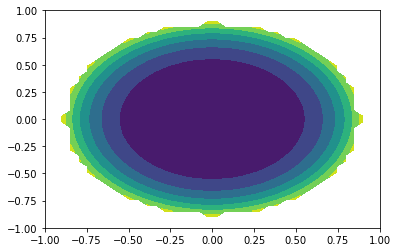

Error: 0.005079609830197294


In [13]:
# TODO: bug in agd freeway?


def A_zero(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B_quartic(x, r, p):
    return 48 * lp.dot_VV(x, x) ** 2


u = newton_root(
    SchemeDirichlet,
    np.zeros(x.shape[1:]),
    (x, domain_ball, A_zero, B_quartic, 0.9 ** 2, stencil),
)

plt.contourf(*x, np.where(domain_ball.level(x) < 0, u, np.nan))
plt.show()


def ExactQuartic(x):
    return lp.dot_VV(x, x) ** 2


error = np.where(domain_ball.level(x) < 0, u - ExactQuartic(x), 0)
print("Error:", np.max(np.abs(error)))

## 5. Optimal transport boundary conditions

For any $x \in \overline \Omega$ and $r \in \mathbb{R}$, let $P_{\Omega^*}(x, r) \subset \mathbb{R}^2$ be a convex set. We aim to approximate a function $u \colon \overline \Omega \to \mathbb{R}$ which is an admissible solution to the Monge-Ampère equation on $\Omega$ and such that for any $x \in \partial \Omega$,
\begin{equation}
    D u(x) \in \partial P_{\Omega^*}(x, u(x)).
\end{equation}
If $\sigma \colon \Omega \times \mathbb{R} \times \mathbb{R}^2 \to \mathbb{R}$ is defined by
\begin{equation}
    \sigma(x, r, e) := \sup_{p \in P_{\Omega^*}(x, r)} \langle e, p \rangle,
\end{equation}
then the boundary condition is equivalent to
\begin{equation}
    \sup_{|e| = 1} \langle e, D u(x) \rangle - \sigma(x, u(x), e) = 0
\end{equation}
for $x \in \partial \Omega$.

We assume that if $x \in \mathcal{G}_h$, then either $x + h e_1 \in \mathcal{G}_h$ or $x - h e_1 \in \mathcal{G}_h$, and either $x + h e_2 \in \mathcal{G}_h$ or $x - h e_2 \in \mathcal{G}_h$, where $(e_1, e_2)$ is the canonical basis of $\mathbb{R}^2$. For $u \colon \mathcal{G}_h \to \mathbb{R}$, we let
\begin{equation}
    D_h u(x) := \begin{pmatrix}
        (\delta_h^{e_1} u(x) - \delta_h^{-e_1} u(x)) / 2 \\
        (\delta_h^{e_2} u(x) - \delta_h^{-e_2} u(x)) / 2
    \end{pmatrix}
\end{equation}
where for $e \in \{\pm e_1, \pm e_2\}$,
\begin{equation}
    \delta_h^e u(x) = \begin{cases}
        \frac{u(x + h e) - u(x)}{h} &\text{if } x + h e \in \mathcal{G}_h, \\
        -\delta_h^{-e} u(x) &\text{else}.
    \end{cases}
\end{equation}
For $u \colon \mathcal{G}_h \to \mathbb{R}$ and $e \in \mathbb{Z}^2$, we let
\begin{equation}
    \Delta_h^e u(x) := \frac{\tilde \delta_h^e u(x) + \tilde \delta_h^{-e} u(x)}{h}
\end{equation}
where
\begin{equation}
    \tilde \delta_h^e u(x) := \begin{cases}
        \frac{u(x + h e) - u(x)}{h} &\text{if } x + h e \in \mathcal{G}_h, \\
        \sigma(x, u(x), e) &\text{else}.
    \end{cases}
\end{equation}

We assume that there is an open domain $\Omega_0 \subset \overline \Omega_0 \subset \Omega$ such that $B(x, r, p) = 0$ whenever $x \in \Omega \setminus \Omega_0$. In the code below, the variable `domain` represents $\Omega_0$, and we always use $[-1, 1]^2$ as the domain $\Omega$.

There may be infinitely many solutions $u$, so we choose $C \in \mathbb{R}$ and try to approximate the one satifying $u(x_0) = C$, for some given point $x_0 \in \Omega_0$. To this end, we solve the following numerical scheme:
\begin{equation}
    \max_{v \in V_3} H(v, B(x, u(x), D_h u(x)), \Delta_h^v [u, A(x, u(x), D_h u(x))](x)) + u(x_0) - C = 0.
\end{equation}

In [14]:
def SchemeBV2(u, x, domain, A, B, C, sigma, stencil):
    bc = Domain.Dirichlet(Domain.Box([[-1, 1], [-1, 1]]), np.inf, x)

    du0 = bc.DiffUpwind(u, [[1, 0], [0, 1]])
    du1 = bc.DiffUpwind(u, [[-1, 0], [0, -1]])
    assert np.sum(np.logical_and(du0 == np.inf, du1 == np.inf)) == 0
    du0 = np.where(du0 == np.inf, -du1, du0)
    du1 = np.where(du1 == np.inf, -du0, du1)
    du = (du0 - du1) / 2

    du0 = bc.DiffUpwind(u, stencil.V1)
    du0 = np.where(
        du0 == np.inf,
        sigma(
            np.expand_dims(x, 1),
            np.expand_dims(u, 0),
            np.multiply.outer(stencil.V1, np.ones(x.shape[1:])),
        ),
        du0,
    )
    du1 = bc.DiffUpwind(u, -stencil.V1)
    du1 = np.where(
        du1 == np.inf,
        sigma(
            np.expand_dims(x, 1),
            np.expand_dims(u, 0),
            np.multiply.outer(-stencil.V1, np.ones(x.shape[1:])),
        ),
        du1,
    )
    d2u = (du0 + du1) / bc.gridscale

    return np.where(
        bc.interior,
        Scheme(A(x, u, du), np.where(domain.level(x) < 0, B(x, u, du), 0), d2u, stencil)
        + u.flatten()[np.argmin(domain.level(x))]
        - C,
        u - bc.grid_values,
    )

### Application to reflector design

Let $\Omega$, $\Omega^* \subset \mathbb{R}^2$ be open domains. We consider a collimated light source consisting of rays originating from points of $\Omega^* \times \{0\}$ in the direction $e_3 := (0, 0, 1)$. Those rays are reflected downwards by a surface $\mathcal{R} \subset \mathbb{R}^2 \times \mathbb{R}_+$ and hit the plane $\mathbb{R}^2 \times \{0\}$ in points of the domain $\Omega \times \{0\}$.

Let $g \colon \Omega^* \to \mathbb{R}_+^*$ describe the intensity of light originating from $\Omega^* \times \{0\}$, and $f \colon \Omega \to \mathbb{R}$ be such that
\begin{equation}
    \int_\Omega f(x)\, d x = \int_{\Omega^*} g(y)\, d y.
\end{equation}
We aim to compute a suitable shape for the reflecting surface $\mathcal{R}$ so that the intensity of light hitting the target $\Omega \times \{0\}$ is described by the function $f$.

We assume that the surface $\mathcal{R}$ is of form $\{(y, v(y)) \mid y \in \Omega^*\}$, for some function $v \colon \Omega^* \to \mathbb{R}_+^*$, and that there is $u \colon \Omega \to \mathbb{R}_+^*$ such that
\begin{equation}
    v(y) = \sup_{x \in \Omega} H(x, y, u(x)),
\end{equation}
\begin{equation}
    u(x) = \sup_{y \in \Omega^*} G(x, y, v(y)),
\end{equation}
where
\begin{equation}
    H(x, y, r) := \frac{1}{2 r} - \frac{r}{2} |x - y|^2,
\end{equation}
\begin{equation}
    G(x, y, z) := \frac{1}{z + (|x - y|^2 + z^2)^{1/2}}.
\end{equation}
Then for any $x \in \Omega$,
\begin{equation}
    v(Y(x, u(x), D u(x))) = Z(x, u(x), D u(x))
\end{equation}
where
\begin{equation}
    Y(x, r, p) := x + \frac{p}{r^3 + r (r^4 - |p|^2)^{1/2}},
\end{equation}
\begin{equation}
    Z(x, r, p) := \frac{(r^4 - |p|^2)^{1/2}}{r^3 + r (r^4 - |p|^2)^{1/2}},
\end{equation}
and $u$ is an admissible solution to the Monge-Ampère equation with
\begin{equation}
    A(x, r, p) := \frac{3 r^2 + (r^4 - |p|^2)^{1/2}}{r^3} p p^\top - (r^3 + r (r^4 - |p|^2)^{1/2}) I_2,
\end{equation}
\begin{equation}
    B(x, r, p) := (r^4 - |p|^2)^{1/2} (r^2 + (r^4 - |p|^2)^{1/2})^2 \frac{f(x)}{g(Y(x, r, p))}.
\end{equation}
Moreover, for any $x \in \partial \Omega$,
\begin{equation}
    Y(x, u(x), D u(x)) \in \partial \Omega^*.
\end{equation}

Using that
\begin{equation}
    y = Y(x, r, p) \iff p = P(x, y, r)
\end{equation}
where
\begin{equation}
    P(x, y, r) := \frac{2 r^3 (y - x)}{1 + r^2 |y - x|^2},
\end{equation}
the last condition may be rewritten as
\begin{equation}
    D u(x) \in \partial P(x, \Omega^*, r).
\end{equation}
We may either approximate
\begin{equation}
    \sigma(x, r, e) := \max_{y \in \Omega^*} \langle e, P(x, y, r) \rangle
\end{equation}
by a maximum over a discrete subset of $\partial \Omega^*$ or by assuming that $1 + r^2 |y - x|^2$ is close to one.

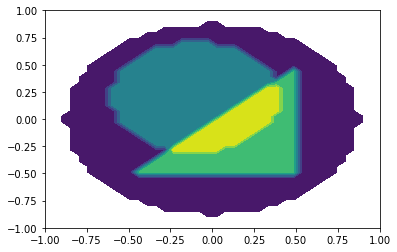

In [15]:
def f(x):
    return (
        1 / (3 * 0.9 ** 2)
        + np.where((x[0] + 0.1) ** 2 + (x[1] - 0.2) ** 2 < 0.25, 1 / (3 * 0.5 ** 2), 0)
        + np.where(
            np.logical_and(np.logical_and(x[0] < 0.5, x[1] > -0.5), x[0] - x[1] > 0,),
            2 * np.pi / 3,
            0,
        )
    )


plt.contourf(*x, np.where(domain_ball.level(x) < 0, f(x), np.nan))
plt.show()

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Sparse.py:100: RuntimeWarning: divide by zero encountered in true_divide
  _concatenate(self.coef*_add_dim(1/other.value),other.coef*_add_dim(-self.value/other.value**2)),


Iteration: 1  Residue norm: 0.03152794519754967
Iteration: 2  Residue norm: 0.01638739823299952
Iteration: 3  Residue norm: 0.014081309086812377
Iteration: 4  Residue norm: 0.0013355731780688718
Iteration: 5  Residue norm: 0.0013074280638264296
Iteration: 6  Residue norm: 0.00041637081591058833
Iteration: 8  Residue norm: 9.041749704384594e-05
Iteration: 10  Residue norm: 9.427335231904088e-09
Target residue reached. Terminating.


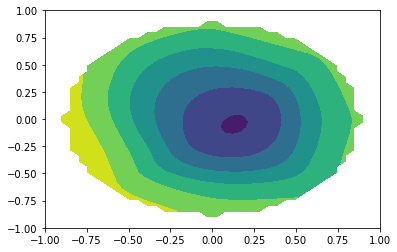

In [16]:
def A_reflector(x, r, p):
    tmp = 1 + np.sqrt(1 - lp.dot_VV(p, p) / r ** 4)
    return (2 + tmp) / r * lp.outer(p, p) - r ** 3 * tmp * lp.identity(x.shape[1:])


def B_reflector(x, r, p):
    tmp = 1 + np.sqrt(1 - lp.dot_VV(p, p) / r ** 4)
    return r ** 6 * (tmp ** 3 - tmp ** 2) * f(x)


def sigma_reflector(x, r, e):
    return 2 * r ** 3 * (np.sqrt(lp.dot_VV(e, e)) - lp.dot_VV(x, e))


u = newton_root(
    SchemeBV2,
    np.full(x.shape[1:], 0.1),
    (x, domain_ball, A_reflector, B_reflector, 0.1, sigma_reflector, stencil),
)

plt.contourf(*x, np.where(domain_ball.level(x) < 0, u, np.nan))
plt.show()

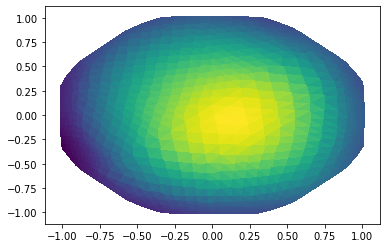

In [17]:
def Y_reflector(x, r, p):
    tmp = 1 + np.sqrt(1 - lp.dot_VV(p, p) / r ** 4)
    return x + 1 / (r ** 3 * tmp) * p


def Z_reflector(x, r, p):
    tmp = 1 + np.sqrt(1 - lp.dot_VV(p, p) / r ** 4)
    return (1 - 1 / tmp) / r


gridscale = x[0, 1, 0] - x[0, 0, 0]
du = fd.DiffCentered(u, [[1, 0], [0, 1]], gridscale)

interior = domain_ball.level(x) < 0
y = Y_reflector(x[:, interior], u[interior], du[:, interior])
z = Z_reflector(x[:, interior], u[interior], du[:, interior])

plt.tripcolor(*y, z)
plt.show()

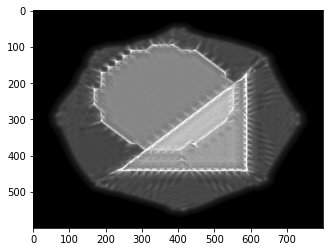

In [18]:
simulate_reflector(y, z)

#### Far field reflector

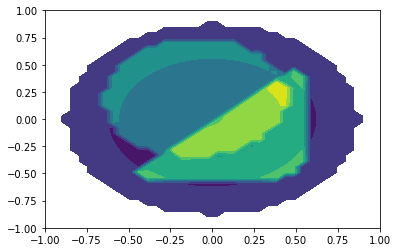

In [19]:
alpha = (np.sqrt(1 + 0.9 ** 2) - 1) / 0.9 ** 2


def f2(x):
    return (
        4
        * alpha ** 2
        * (1 + alpha ** 2 * lp.dot_VV(x, x))
        / (1 - alpha ** 2 * lp.dot_VV(x, x)) ** 3
    ) * f(2 * alpha * x / (1 - alpha ** 2 * lp.dot_VV(x, x)))


plt.contourf(*x, np.where(domain_ball.level(x) < 0, f2(x), np.nan))
plt.show()

Iteration: 1  Residue norm: 8.842185552579979
Iteration: 2  Residue norm: 4.60002991162849
Iteration: 3  Residue norm: 2.4597624726888094
Iteration: 4  Residue norm: 1.327068388534354
Iteration: 5  Residue norm: 0.3195555514895063
Iteration: 6  Residue norm: 0.13104167873293168
Iteration: 8  Residue norm: 0.025997914230372045
Iteration: 10  Residue norm: 0.004864144708873912
Iteration: 12  Residue norm: 1.1651388499844817e-09
Target residue reached. Terminating.


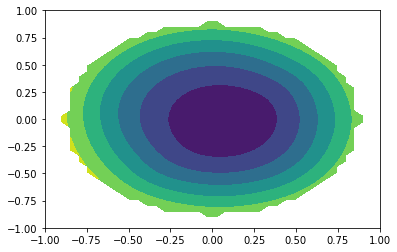

In [20]:
def A_reflector2(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B_reflector2(x, r, p):
    return alpha ** 2 * f2(x)


def sigma_reflector2(x, r, e):
    return alpha * np.sqrt(lp.dot_VV(e, e))


u = newton_root(
    SchemeBV2,
    np.zeros(x.shape[1:]),
    (x, domain_ball, A_reflector2, B_reflector2, 0, sigma_reflector2, stencil),
)

plt.contourf(*x, np.where(domain_ball.level(x) < 0, u, np.nan))
plt.show()

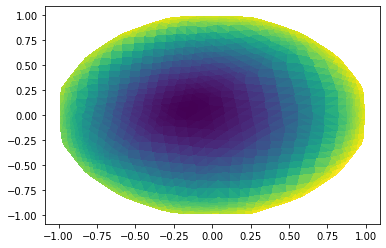

In [21]:
def Y_reflector2(p):
    return p / alpha


def Z_reflector2(x, r, p):
    return lp.dot_VV(x, p) - r


gridscale = x[0, 1, 0] - x[0, 0, 0]
du = fd.DiffCentered(u, [[1, 0], [0, 1]], gridscale)

interior = domain_ball.level(x) < 0
y = Y_reflector2(du[:, interior])
z = Z_reflector2(x[:, interior], u[interior], du[:, interior])

im = plt.tripcolor(*y, z)
plt.show()

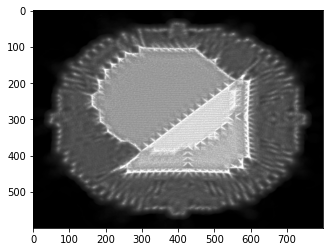

In [22]:
simulate_reflector(y, z + 100, intensity=30, target_radius=100)